# Deep transfer learning tutorial
This notebook contains two popular paradigms of transfer learning: **Finetune** and **Domain adaptation**.
Since most of the codes are shared by them, we show how they work in just one single notebook.
I think that transfer learning and domain adaptation are both easy, and there's no need to create some library or packages for this simple purpose, which only makes things difficult.
The purpose of this note book is we **don't even need to install a library or package** to train a domain adaptation or finetune model.

## Preparation

First of all, install `pytorch` and `torchvision`.
Skip this step if you already installed.

Then, prepare the dataset you need. Here, we wil use the classical **Office-31** dataset.
We just need to download it, and then extract it.
Skip this step if you already have the data on your disk.

To verify the dataset, we show its structures.

## Some imports.

In [1]:
import os
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import time
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
torch.cuda.set_device("cuda:0")

Set the dataset folder, batch size, number of classes, and domain name.

In [2]:
data_folder = 'C:/Users/user/OneDrive/Masaüstü/microsoft_malware_classification_challenge_gray'
batch_size = 16 #32 olmuyor
n_class = 9
domain_src, domain_tar, domain_val, domain_test = 'source_domain_grayscale', 'target_domain_grayscale', 'grayscale_val_domain', 'grayscale_test_domain'

## Data load
Now, define a data loader function.

In [3]:
def load_data(root_path, domain, batch_size, phase):
    transform_dict = {
        'src': transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ]),
        'tar': transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ]),
         'val': transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ]),
         'test': transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
         ])}
    data = datasets.ImageFolder(root=os.path.join(root_path, domain), transform=transform_dict[phase])
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=phase=='src', drop_last=phase=='tar', num_workers=4)
    return data_loader

Load the data using the above function to test it.

In [4]:
src_loader = load_data(data_folder, domain_src, batch_size, phase='src')
tar_loader = load_data(data_folder, domain_tar, batch_size, phase='tar')
val_loader = load_data(data_folder, domain_val, batch_size, phase='val')
test_data_loader = load_data(data_folder, domain_test, batch_size, phase='test')
print(f'Source data number: {len(src_loader.dataset)}')
print(f'Target data number: {len(tar_loader.dataset)}')
print(f'Domain val data number: {len(val_loader.dataset)}')
print(f'Domain test data number: {len(test_data_loader.dataset)}')

Source data number: 4172
Target data number: 2780
Domain val data number: 1737
Domain test data number: 2171


## Define the finetune model
The model for finetune is based on ResNet-50 for its popularity. Of course you can use other base networks.
The main logic of this class is to get the pretrained ResNet-50, use all of its layers but the last one, which we will replace by a new FC layer for classification. Since the original ResNet-50 is for 1000 classes classification, we only need it to classify 31.

In [ ]:
class TransferModel(nn.Module):
    def __init__(self,
                base_model : str = 'resnet50',
                pretrain : bool = True,
                n_class : int = 31):
        super(TransferModel, self).__init__()
        self.base_model = base_model
        self.pretrain = pretrain
        self.n_class = n_class
        if self.base_model == 'resnet50':
            self.model = torchvision.models.resnet50(pretrained=True)
            n_features = self.model.fc.in_features
            fc = torch.nn.Linear(n_features, n_class)
            self.model.fc = fc
        else:
            # Use other models you like, such as vgg or alexnet
            pass
        self.model.fc.weight.data.normal_(0, 0.005)
        self.model.fc.bias.data.fill_(0.1)

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        return self.forward(x)

Now, we define a model and test it using a random tensor.

In [ ]:
model = TransferModel().cuda()
RAND_TENSOR = torch.randn(1, 3, 224, 224).cuda()
output = model(RAND_TENSOR)
print(output)
print(output.shape)

## Finetune ResNet-50
Define some variables. Note that Office-31 doesn't have a validation set, so we use its target domain as the validation set.

Now the most important part: write the finetune function.
This function is pretty easy: it is basically a standard classification function. We train it on the 'src' domain, valid it on the 'val' domain, and then test it on the 'tar' domain.
The only difference is that Office-31 dataset has no validation set, so we will use the target domain as the validation set. For your own data, you should use its standard validation set.
We also set an early_stop variable.

In [5]:
dataloaders = {'src': src_loader,
               'val': val_loader,
               'tar': tar_loader,
               'test': test_data_loader}
n_epoch = 120
criterion = nn.CrossEntropyLoss()
early_stop = 20

In [ ]:
def finetune(model, dataloaders, optimizer):
    since = time.time()
    best_acc = 0
    stop = 0
    for epoch in range(0, n_epoch):
        stop += 1
        # You can uncomment this line for scheduling learning rate
        # lr_schedule(optimizer, epoch)
        for phase in ['src', 'val', 'tar']:
            if phase == 'src':
                model.train()
            else:
                model.eval()
            total_loss, correct = 0, 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.cuda(), labels.cuda()
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'src'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                preds = torch.max(outputs, 1)[1]
                if phase == 'src':
                    loss.backward()
                    optimizer.step()
                total_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)
            epoch_loss = total_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct.double() / len(dataloaders[phase].dataset)
            print(f'Epoch: [{epoch:02d}/{n_epoch:02d}]---{phase}, loss: {epoch_loss:.6f}, acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                stop = 0
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'model.pkl')
        if stop >= early_stop:
            break
        print()

    time_pass = time.time() - since
    print(f'Training complete in {time_pass // 60:.0f}m {time_pass % 60:.0f}s')

Now, define some train parameters and the optimizer. For simplicity, we use SGD, and the learning rate for the FC layer is 10 times of other layers, which is a common trick.

In [ ]:
param_group = []
learning_rate = 0.0001
momentum = 5e-4
for k, v in model.named_parameters():
    if not k.__contains__('fc'):
        param_group += [{'params': v, 'lr': learning_rate}]
    else:
        param_group += [{'params': v, 'lr': learning_rate * 10}]
optimizer = torch.optim.SGD(param_group, momentum=momentum)

## Train and test
Now we can train and test it.

In [ ]:
finetune(model, dataloaders, optimizer)

In [6]:
def test(model, target_test_loader):
    model.eval()
    correct = 0
    len_target_dataset = len(target_test_loader.dataset)
    with torch.no_grad():
        for data, target in target_test_loader:
            data, target = data.cuda(), target.cuda()
            s_output = model.predict(data)
            pred = torch.max(s_output, 1)[1]
            correct += torch.sum(pred == target)
    acc = correct.double() / len(target_test_loader.dataset)
    return acc

In [ ]:
model.load_state_dict(torch.load('model.pkl'))
acc_test = test(model, dataloaders['tar'])
print(f'Test accuracy: {acc_test}')

It's over for finetune. Of course, you should use some learning rate decay trick in real training. But that is not our goal.
Next, we will continue to use the same dataloader for domain adaptation.

## Domain adaptation
Now we are in domain adaptation.

## Logic for domain adaptation
The logic for domain adaptation is mostly similar to finetune, except that we must add a loss to the finetune model to **regularize the distribution discrepancy** between two domains.
Therefore, the most different parts are:
- Define some **loss function** to compute the distance (which is the main contribution of most existing DA papers)
- Define a new model class to use that loss function for **forward** pass.
- Write a slightly different script to train, since we have to take both **source data, source label, and target data**.

### Loss function
The most popular loss function for DA is **MMD (Maximum Mean Discrepancy)**. For comaprison, we also use another popular loss **CORAL (CORrelation ALignment)**. They are defined as follows.

#### MMD loss

In [7]:
class MMD_loss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss


#### CORAL loss

In [8]:
def CORAL(source, target):
    d = source.size(1)
    ns, nt = source.size(0), target.size(0)

    # source covariance
    tmp_s = torch.ones((1, ns)).cuda() @ source
    cs = (source.t() @ source - (tmp_s.t() @ tmp_s) / ns) / (ns - 1)

    # target covariance
    tmp_t = torch.ones((1, nt)).cuda() @ target
    ct = (target.t() @ target - (tmp_t.t() @ tmp_t) / nt) / (nt - 1)

    # frobenius norm
    loss = (cs - ct).pow(2).sum().sqrt()
    loss = loss / (4 * d * d)

    return loss

### Model
Now we use ResNet-50 again just like finetune. The difference is that we rewrite the ResNet-50 class to drop its last layer.

In [9]:
from torchvision import models
#from efficientnet_pytorch import EfficientNet
import torch.nn as nn

class EfficientNetFc(nn.Module):
    def __init__(self):
        super(EfficientNetFc, self).__init__()
        efficientnet_b6 = models.efficientnet_b6(weights='IMAGENET1K_V1')
        
        # Extract layers from the pre-trained model
        self.features = efficientnet_b6.features
        self.avgpool = efficientnet_b6.avgpool
        self.__in_features = efficientnet_b6.classifier[1].in_features
        
        # Remove the original classifier
        self.classifier = nn.Identity()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

    def output_num(self):
        return self.__in_features
      

# Example usage:
# model_b5 = EfficientNetFc(model_name='efficientnet-b5')
# model_b6 = EfficientNetFc(model_name='efficientnet-b6')
# model_b7 = EfficientNetFc(model_name='efficientnet-b7')

Now the main class for DA. We take ResNet-50 as its backbone, add a bottleneck layer and our own FC layer for classification.
Note the `adapt_loss` function. It is just using our predefined MMD or CORAL loss. Of course you can use your own loss.

In [10]:
class TransferNet(nn.Module):
    def __init__(self,
                 num_class,
                 base_net='efficientnet',
                 transfer_loss='coral',
                 use_bottleneck=True,
                 bottleneck_width=256,
                 width=1024):
        super(TransferNet, self).__init__()
        if base_net == 'efficientnet':
            self.base_network = EfficientNetFc()
        else:
            # Your own basenet
            return
        self.use_bottleneck = use_bottleneck
        self.transfer_loss = transfer_loss
        bottleneck_list = [nn.Linear(self.base_network.output_num(
        ), bottleneck_width), nn.BatchNorm1d(bottleneck_width), nn.ReLU(), nn.Dropout(0.5)]
        self.bottleneck_layer = nn.Sequential(*bottleneck_list)
        classifier_layer_list = [nn.Linear(self.base_network.output_num(), width), nn.ReLU(), nn.Dropout(0.5),
                                 nn.Linear(width, num_class)]
        self.classifier_layer = nn.Sequential(*classifier_layer_list)

        self.bottleneck_layer[0].weight.data.normal_(0, 0.005)
        self.bottleneck_layer[0].bias.data.fill_(0.1)
        for i in range(2):
            self.classifier_layer[i * 3].weight.data.normal_(0, 0.01)
            self.classifier_layer[i * 3].bias.data.fill_(0.0)

    def forward(self, source, target):
        source = self.base_network(source)
        target = self.base_network(target)
        source_clf = self.classifier_layer(source)
        if self.use_bottleneck:
            source = self.bottleneck_layer(source)
            target = self.bottleneck_layer(target)
        transfer_loss = self.adapt_loss(source, target, self.transfer_loss)
        return source_clf, transfer_loss

    def predict(self, x):
        features = self.base_network(x)
        clf = self.classifier_layer(features)
        return clf

    def adapt_loss(self, X, Y, adapt_loss):
        """Compute adaptation loss, currently we support mmd and coral

        Arguments:
            X {tensor} -- source matrix
            Y {tensor} -- target matrix
            adapt_loss {string} -- loss type, 'mmd' or 'coral'. You can add your own loss

        Returns:
            [tensor] -- adaptation loss tensor
        """
        if adapt_loss == 'mmd':
            mmd_loss = MMD_loss()
            loss = mmd_loss(X, Y)
        elif adapt_loss == 'coral':
            loss = CORAL(X, Y)
        else:
            # Your own loss
            loss = 0
        return loss

### Train
Now the train part.

In [11]:
transfer_loss = 'coral'
learning_rate = 0.01 #0.0001
transfer_model = TransferNet(n_class, transfer_loss=transfer_loss, base_net='efficientnet').cuda()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)
lamb = 10 # weight for transfer loss, it is a hyperparameter that needs to be tuned

In [12]:
cls_loss_array = []
transfer_loss_array = []
total_loss_array = []
acc_array = []

In [13]:
writer = SummaryWriter("C:/Users/user/efficientnet_b7_malware_grayscale")

The main train function. Since we have to enumerate all source and target samples, we have to use `zip` operation to enumerate each pair of these two domains. It is common that two domains have different sizes, but we think by randomly sampling them in many epochs, we may sample each one of them.

In [14]:
def train(dataloaders, model, optimizer):
    source_loader, target_train_loader, target_test_loader = dataloaders['src'], dataloaders['tar'], dataloaders['val']
    len_source_loader = len(source_loader)
    len_target_loader = len(target_train_loader)
    best_acc = 0
    stop = 0
    n_batch = min(len_source_loader, len_target_loader)
    for e in range(n_epoch):
        stop += 1
        train_loss_clf, train_loss_transfer, train_loss_total = 0, 0, 0
        model.train()
        for (src, tar) in zip(source_loader, target_train_loader):
            data_source, label_source = src
            data_target, _ = tar
            data_source, label_source = data_source.cuda(), label_source.cuda()
            data_target = data_target.cuda()

            optimizer.zero_grad()
            label_source_pred, transfer_loss = model(data_source, data_target)
            clf_loss = criterion(label_source_pred, label_source)
            loss = clf_loss + lamb * transfer_loss
            loss.backward()
            optimizer.step()
            train_loss_clf = clf_loss.detach().item() + train_loss_clf
            train_loss_transfer = transfer_loss.detach().item() + train_loss_transfer
            train_loss_total = loss.detach().item() + train_loss_total
        acc = test(model, target_test_loader)
        class_loss = train_loss_clf/n_batch
        transfer_loss = train_loss_transfer/n_batch
        total_loss = train_loss_total/n_batch
        writer.add_scalar("cls_loss", class_loss, e)
        writer.add_scalar("transfer_loss", transfer_loss, e)
        writer.add_scalar("total_loss", total_loss, e)
        writer.add_scalar("acc", acc, e)
        cls_loss_array.append(class_loss)
        transfer_loss_array.append(transfer_loss)
        total_loss_array.append(total_loss)
        acc_array.append(acc)
        print(f'Epoch: [{e:2d}/{n_epoch}], cls_loss: {train_loss_clf/n_batch:.4f}, transfer_loss: {train_loss_transfer/n_batch:.4f}, total_Loss: {train_loss_total/n_batch:.4f}, acc: {acc:.4f}')
        if best_acc < acc:
            best_acc = acc
            torch.save(model.state_dict(), 'transefficientnetb7model.pt')
            stop = 0
        if stop >= early_stop:
            writer.close()
            break
    writer.close()

In [15]:
train(dataloaders, transfer_model, optimizer)

Epoch: [ 0/120], cls_loss: 1.6275, transfer_loss: 0.0003, total_Loss: 1.6302, acc: 0.4778
Epoch: [ 1/120], cls_loss: 1.0422, transfer_loss: 0.0002, total_Loss: 1.0441, acc: 0.8238
Epoch: [ 2/120], cls_loss: 0.7766, transfer_loss: 0.0001, total_Loss: 0.7780, acc: 0.8975
Epoch: [ 3/120], cls_loss: 0.6694, transfer_loss: 0.0001, total_Loss: 0.6705, acc: 0.8837
Epoch: [ 4/120], cls_loss: 0.5768, transfer_loss: 0.0001, total_Loss: 0.5776, acc: 0.9292
Epoch: [ 5/120], cls_loss: 0.5422, transfer_loss: 0.0001, total_Loss: 0.5428, acc: 0.8993
Epoch: [ 6/120], cls_loss: 0.5146, transfer_loss: 0.0000, total_Loss: 0.5151, acc: 0.9234
Epoch: [ 7/120], cls_loss: 0.4954, transfer_loss: 0.0000, total_Loss: 0.4958, acc: 0.9349
Epoch: [ 8/120], cls_loss: 0.4476, transfer_loss: 0.0000, total_Loss: 0.4479, acc: 0.9257
Epoch: [ 9/120], cls_loss: 0.4345, transfer_loss: 0.0000, total_Loss: 0.4348, acc: 0.9257
Epoch: [10/120], cls_loss: 0.3908, transfer_loss: 0.0000, total_Loss: 0.3910, acc: 0.9493
Epoch: [11

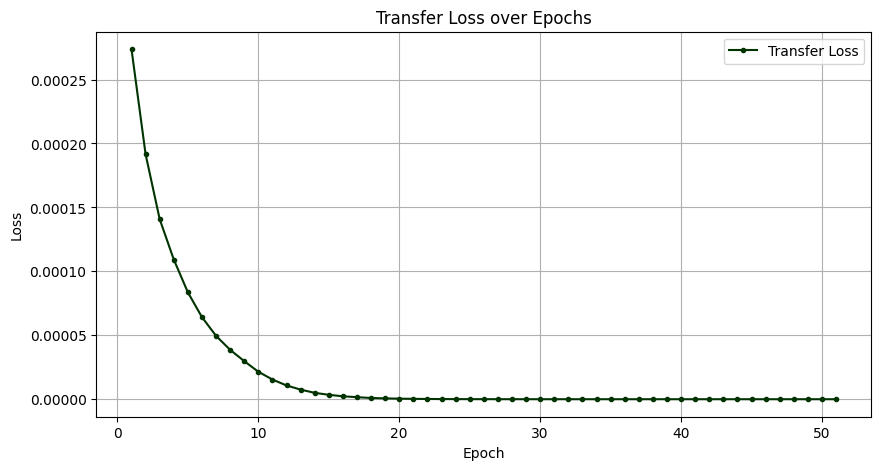

In [16]:
import matplotlib.pyplot as plt

# Assume the number of epochs is equal to the length of the arrays
epochs = range(1, len(cls_loss_array) + 1)

# Plotting the losses
plt.figure(figsize=(10, 5))

#plt.plot(epochs, cls_loss_array, label='Classification Loss', color='blue', marker='o')
plt.plot(epochs, transfer_loss_array, label='Transfer Loss', color='#003300', marker='.')
#plt.plot(epochs, total_loss_array, label='Total Loss', color='red', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transfer Loss over Epochs')
plt.legend()
plt.grid(True)

plt.show()

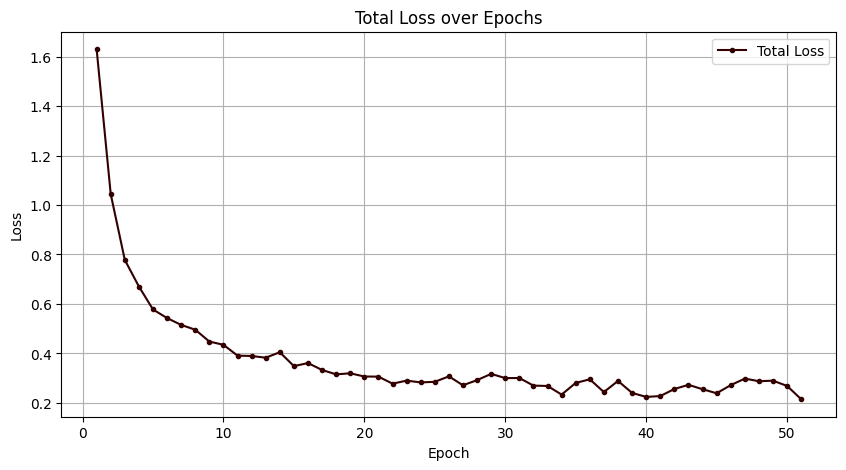

In [17]:
# Assume the number of epochs is equal to the length of the arrays
epochs = range(1, len(cls_loss_array) + 1)

# Plotting the losses
plt.figure(figsize=(10, 5))

#plt.plot(epochs, cls_loss_array, label='Classification Loss', color='blue', marker='o')
#plt.plot(epochs, transfer_loss_array, label='Transfer Loss', color='green', marker='o')
plt.plot(epochs, total_loss_array, label='Total Loss', color='#330000', marker='.')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss over Epochs')
plt.legend()
plt.grid(True)

plt.show()

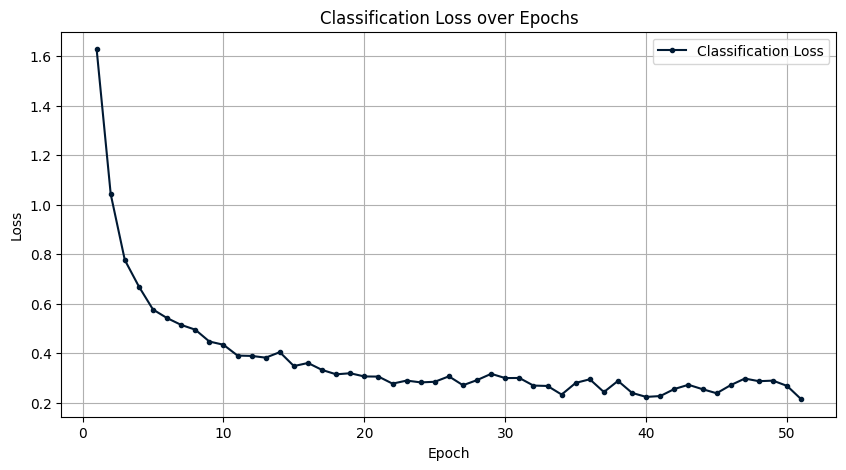

In [18]:
# Assume the number of epochs is equal to the length of the arrays
epochs = range(1, len(cls_loss_array) + 1)

# Plotting the losses
plt.figure(figsize=(10, 5))

plt.plot(epochs, cls_loss_array, label='Classification Loss', color='#001933', marker='.')
#plt.plot(epochs, transfer_loss_array, label='Transfer Loss', color='green', marker='o')
#plt.plot(epochs, total_loss_array, label='Total Loss', color='red', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss over Epochs')
plt.legend()
plt.grid(True)

plt.show()

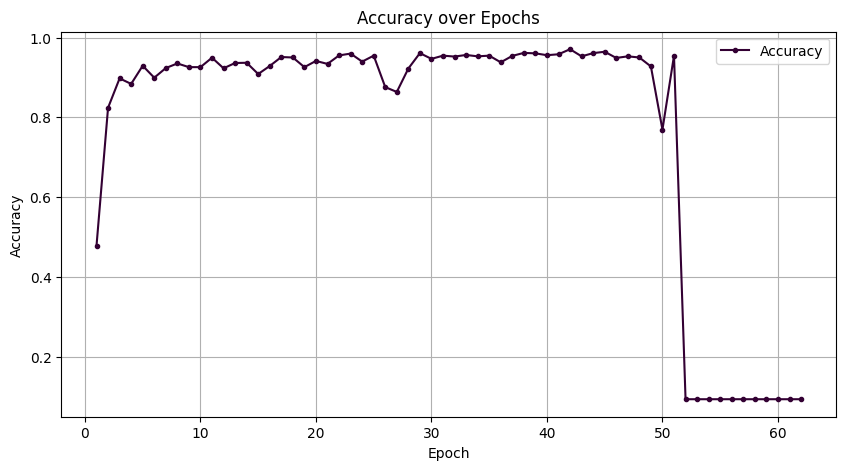

In [20]:
acc_array_cpu = [tensor.cpu().numpy() for tensor in acc_array]

plt.figure(figsize=(10, 5))

plt.plot(epochs, acc_array_cpu, label='Accuracy', color='#330033', marker='.')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.show()

In [21]:
transfer_model.load_state_dict(torch.load('C:/Users/user/OneDrive/Masaüstü/EfficientNet_Compound_Scalig/transefficientnetb7model.pt'))
acc_test = test(transfer_model, dataloaders['test'])
print(f'Test accuracy: {acc_test}')

Test accuracy: 0.9585444495624137


Text(92.109375, 0.5, 'True labels')

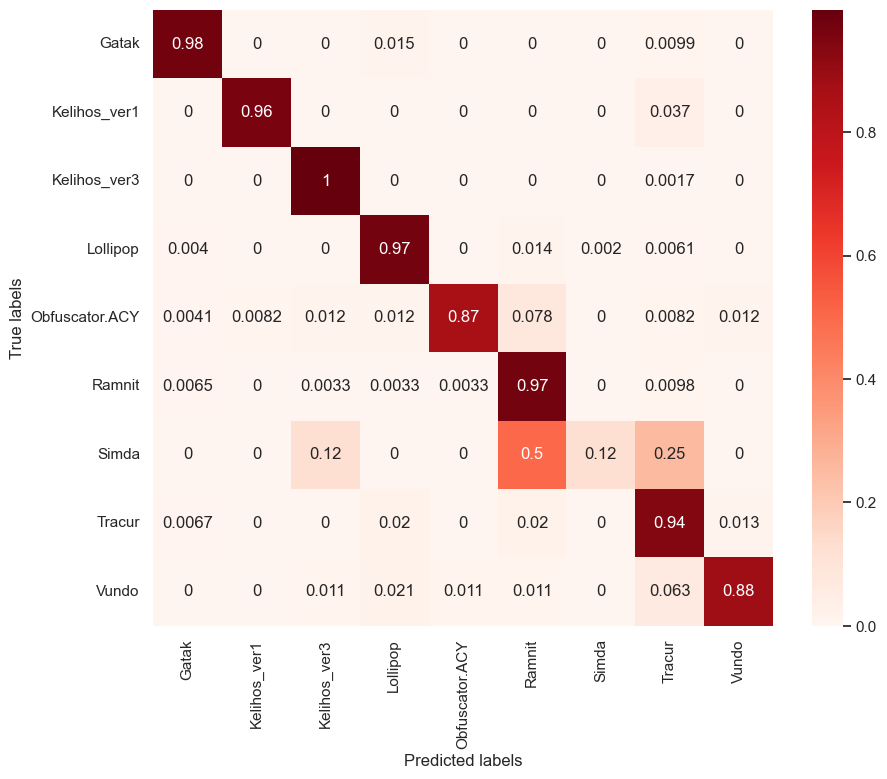

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
predicted_labels = []
true_labels = []
label_names = ['Gatak', 'Kelihos_ver1', 'Kelihos_ver3', 'Lollipop', 'Obfuscator.ACY', 'Ramnit', 'Simda', 'Tracur', 'Vundo']
transfer_model.eval()
with torch.no_grad():
    for images, target in dataloaders['test']:
        images = images.cuda()
        labels = target.cuda()
        outputs = transfer_model.predict(images)
        predicted = torch.max(outputs, 1)[1]
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
normalized_matrix = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix, annot=True, cmap="Reds", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score



# Set the model to evaluation mode
transfer_model.eval()

# Initialize lists to hold true and predicted labels
true_labels = []
pred_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = transfer_model.predict(images)
        preds = torch.max(outputs, 1)[1]
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9009
Recall: 0.8554
F1 Score: 0.8647


Now we are done.

You see, we don't even need to install a library or package to train a domain adaptation or finetune model.
In your own work, you can also use this notebook to test your own algorithms.